In [18]:
from google.cloud import bigquery
import polars as pl
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
client = bigquery.Client(project="rhamre")

c:\Users\rache\AppData\Local\Programs\Python\Python312\Lib\site-packages\google\auth\_default.py:76: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


In [24]:
query = '''
WITH rhamre_data AS (
  SELECT 
    EXTRACT(year FROM datetime) AS year,
    EXTRACT(month FROM datetime) AS month,
    COUNT(*) AS transaction_count
  FROM `rhamre.wedge.transArchive*`
  GROUP BY year, month
),
umt_msba_data AS (
  SELECT 
    EXTRACT(year FROM datetime) AS year,
    EXTRACT(month FROM datetime) AS month,
    COUNT(*) AS transaction_count
  FROM `umt-msba.wedge_transactions.transArchive*`
  GROUP BY year, month
)
SELECT 
  COALESCE(r.year, u.year) AS year,
  COALESCE(r.month, u.month) AS month,
  r.transaction_count AS rhamre_transaction_count,
  u.transaction_count AS umt_transaction_count
FROM rhamre_data r
FULL OUTER JOIN umt_msba_data u
  ON r.year = u.year AND r.month = u.month
  ORDER BY year, month;
'''

In [25]:
query_job = client.query(query)
results = query_job.result()

In [26]:
results_df = results.to_dataframe()

c:\Users\rache\AppData\Local\Programs\Python\Python312\Lib\site-packages\google\cloud\bigquery\table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


In [33]:
results_df.head()

,year,month,rhamre_transaction_count,umt_transaction_count,index
0,1970,1,14,<NA>,0
1,2010,1,998863,998863,1
2,2010,2,942575,942575,2
3,2010,3,1056892,1056892,3
4,2010,4,1075796,1075796,4


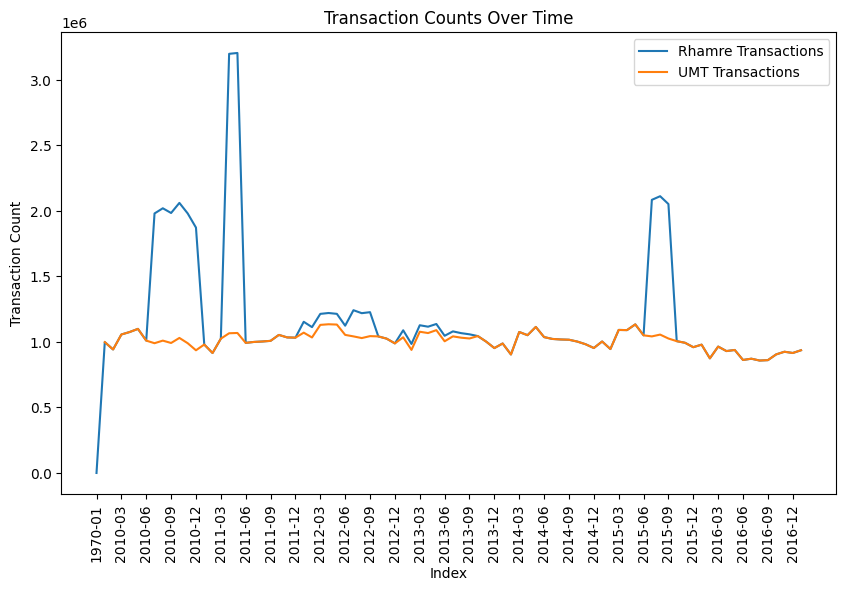

In [37]:
results_df['index'] = range(len(results_df))

plt.figure(figsize=(10, 6))
plt.plot(results_df['index'], results_df['rhamre_transaction_count'], label='Rhamre Transactions')
plt.plot(results_df['index'], results_df['umt_transaction_count'], label='UMT Transactions')
plt.xlabel('Index')
plt.ylabel('Transaction Count')
plt.title('Transaction Counts Over Time')
plt.xticks(
    ticks=results_df['index'][::3], 
    labels=[f"{row['year']}-{row['month']:02d}" for i, row in results_df.iterrows() if i % 3 == 0], 
    rotation=90
)
plt.legend()
plt.show()

The chart above shows that some transactions were uploaded multiple times.


In [38]:
results_df['ratio'] = results_df['rhamre_transaction_count'] / results_df['umt_transaction_count']
results_df.head()


,year,month,rhamre_transaction_count,umt_transaction_count,index,ratio
0,1970,1,14,<NA>,0,<NA>
1,2010,1,998863,998863,1,1.0
2,2010,2,942575,942575,2,1.0
3,2010,3,1056892,1056892,3,1.0
4,2010,4,1075796,1075796,4,1.0


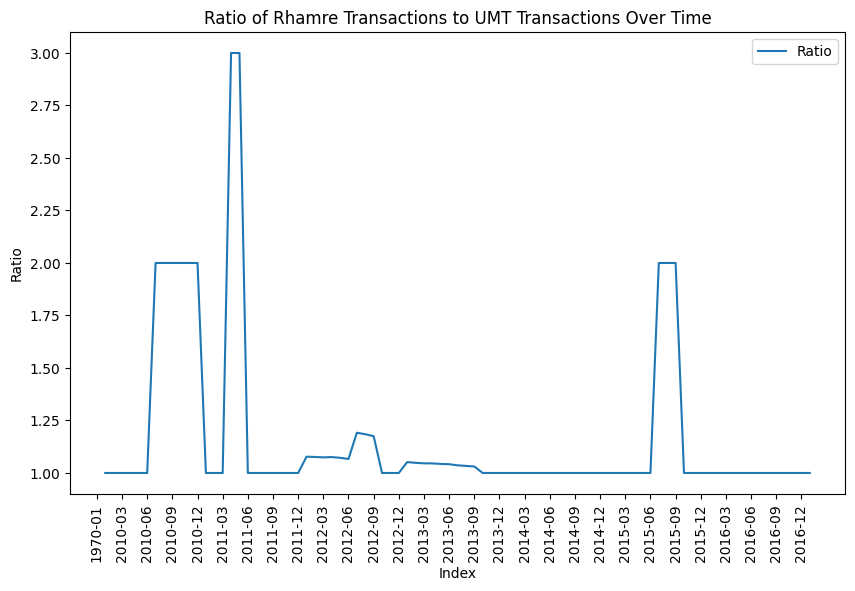

In [39]:
plt.figure(figsize=(10, 6))
plt.plot(results_df['index'], results_df['ratio'], label='Ratio')
plt.xlabel('Index')
plt.ylabel('Ratio')
plt.title('Ratio of Rhamre Transactions to UMT Transactions Over Time')
plt.xticks(
    ticks=results_df['index'][::3], 
    labels=[f"{row['year']}-{row['month']:02d}" for i, row in results_df.iterrows() if i % 3 == 0], 
    rotation=90
)
plt.legend()
plt.show()

In July 2010 - December 2010 and July 2015 - September 2015, records appear to be uploaded twice. In March of 2010, they were uploaded 3 times. Between January 2012 and September 2013, it appears that some records were uploaded multiple times, but not the entire folders. This likely happened due to some folders being partially uploaded.